In [12]:
import os
from dotenv import load_dotenv
import praw
import pandas as pd



In [13]:

load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_SECRET"),
    username=os.getenv("REDDIT_USERNAME"),
    password=os.getenv("REDDIT_PASSWORD"),
    user_agent=os.getenv("REDDIT_USER_AGENT")
)

print("Logged in as:", reddit.user.me())


Logged in as: Sad-State-7591


In [14]:
import re

# Define aliases
am_aliases = [
    "aston martin", "amf1", "alonso", "stroll", 
    "green car", "fernando", "lance", "aston"
]

def contains_alias(text):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    return any(alias in text for alias in am_aliases)

# Step 1: Scrape posts from r/formula1
subreddit = reddit.subreddit("formula1")
posts = []

for post in subreddit.new(limit=1000):
    combined_text = (post.title + " " + post.selftext)
    if contains_alias(combined_text):
        post_data = {
            "type": "post",
            "post_id": post.id,
            "title": post.title,
            "text": post.selftext,
            "upvotes": post.score,
            "created_utc": post.created_utc,
            "url": post.url
        }
        posts.append(post_data)

        # Step 2: Scrape top-level comments from that post
        post.comments.replace_more(limit=0)  # Flatten comment tree
        for comment in post.comments.list():
            if contains_alias(comment.body):
                comment_data = {
                    "type": "comment",
                    "post_id": post.id,
                    "title": "",  # No title for comment
                    "text": comment.body,
                    "upvotes": comment.score,
                    "created_utc": comment.created_utc,
                    "url": f"https://reddit.com{comment.permalink}"
                }
                posts.append(comment_data)

# Create DataFrame
df = pd.DataFrame(posts)
print(f"Total items collected (posts + comments): {len(df)}")

KeyboardInterrupt: 

# BASIC TEXT EXPLORATION

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

# For co-occurrence and lift
from itertools import combinations
from collections import defaultdict

In [ ]:
#Create a data frame with the posts info
df = pd.DataFrame(posts)

#Combine title and text
df['content'] = df['title'] + " " + df['text']

stop_words =  set(stopwords.words('english'))

def basic_preprocessing(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

df['cleaned'] = df['content'].apply(basic_preprocessing)

Top 20 most frequent words:
alonso: 692
stroll: 427
car: 344
aston: 304
team: 256
lance: 236
would: 227
like: 200
hes: 173
driver: 171
think: 167
time: 155
year: 154
season: 150
one: 150
even: 148
race: 141
good: 139
martin: 137
fernando: 137


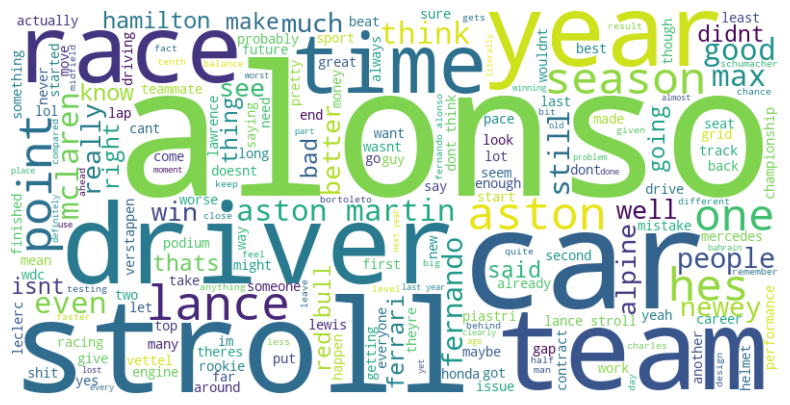

In [ ]:
#Word frequency
# Flatten all tokens into a single list
all_tokens = [token for sublist in df['cleaned'] for token in sublist]

# Count word frequencies
word_freq = Counter(all_tokens)

# Display top 20 words
print("Top 20 most frequent words:")
for word, freq in word_freq.most_common(20):
    print(f"{word}: {freq}")

# Optional: Word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
#I want to check how associated is aston martin with other teams. But for this I have to change the scrapping code to get all the posts and comments, not just the ones with aston martin.
# Step 1: Scrape all recent posts from r/formula1
subreddit = reddit.subreddit("formula1")
items = []

for post in subreddit.new(limit=1000):
    # Append the post (no filtering!)
    items.append({
        "type": "post",
        "post_id": post.id,
        "title": post.title,
        "text": post.selftext,
        "upvotes": post.score,
        "created_utc": post.created_utc,
        "url": post.url
    })

    # Step 2: Scrape all comments from that post
    try:
        post.comments.replace_more(limit=0)  # Load all comments
        for comment in post.comments.list():
            items.append({
                "type": "comment",
                "post_id": post.id,
                "title": "",  # Comments don't have titles
                "text": comment.body,
                "upvotes": comment.score,
                "created_utc": comment.created_utc,
                "url": f"https://reddit.com{comment.permalink}"
            })
    except Exception as e:
        print(f"Error loading comments for post {post.id}: {e}")

# Create DataFrame
df = pd.DataFrame(items)
print(f"Total items collected (posts + comments): {len(df)}")

Total items collected (posts + comments): 112530


In [16]:
#Export the comments to a csv file
df.to_csv("posts_comments.csv", index=False)
#Read the csv file
# df = pd.read_csv("posts_comments.csv")

In [17]:
#Based on those comments + posts associated with AM, I want to know the relationship with other teams
# Create a list of all teams
team_aliases = {
    "aston martin": ["aston martin", "aston", "amf1", "green car", "stroll", "alonso", "fernando", "lance"],
    "red bull": ["red bull", "rb", "rbr", "verstappen", "max", "checo", "perez", "newey", "horner"],
    "mercedes": ["mercedes", "merc", "hamilton", "lewis", "russell", "george", "toto"],
    "ferrari": ["ferrari", "charles", "leclerc", "carlos", "sainz", "fred", "vasseur"],
    "mclaren": ["mclaren", "lando", "norris", "piastri", "oscar", "zak"],
    "alpine": ["alpine", "ocon", "gasly", "renault", "pink car"],
    "williams": ["williams", "albon", "logan", "sargeant"],
    "stake": ["stake", "zhou", "bottas", "sauber"],  # Formerly Alfa Romeo
    "alphatauri": ["alphatauri", "ricciardo", "tsunoda", "rb junior", "rbj", "yuki"],
    "haas": ["haas", "magnussen", "hulkenberg", "nico", "kmag"]
}

alias_to_team = {}
for team, aliases in team_aliases.items():
    for alias in aliases:
        alias_to_team[alias] = team

import re

def extract_teams_from_text(text, alias_lookup):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    mentioned_teams = set()
    for word in words:
        if word in alias_lookup:
            mentioned_teams.add(alias_lookup[word])
    return list(mentioned_teams)

df["teams_mentioned"] = df["text"].apply(lambda x: extract_teams_from_text(x, alias_to_team))



In [18]:
#I want to calculate the co-occurence of each team with AM using Lift
from collections import defaultdict
import pandas as pd

# Total number of comments/posts
N = len(df)

# Step 1: Count total mentions of each team
team_totals = defaultdict(int)
for teams in df["teams_mentioned"]:
    for team in teams:
        team_totals[team] += 1

# Step 2: Count co-mentions with Aston Martin
co_occurrence_counts = defaultdict(int)
for teams in df["teams_mentioned"]:
    if "aston martin" in teams:
        for team in teams:
            if team != "aston martin":
                co_occurrence_counts[team] += 1

# Step 3: Calculate Lift
lift_data = []
count_am = team_totals["aston martin"]

for team, co_count in co_occurrence_counts.items():
    count_b = team_totals[team]
    prob_a = count_am / N
    prob_b = count_b / N
    prob_ab = co_count / N
    lift = prob_ab / (prob_a * prob_b) if prob_a * prob_b > 0 else 0
    lift_data.append((team, co_count, count_b, lift))

# Step 4: Create and sort DataFrame
lift_df = pd.DataFrame(lift_data, columns=["team", "co_mentions_with_aston", "total_mentions", "lift"])
lift_df = lift_df.sort_values(by="lift", ascending=False)

# Show results
print(lift_df)


         team  co_mentions_with_aston  total_mentions      lift
3        haas                     127             903  3.754799
5      alpine                     260            2211  3.139463
7       stake                     102             926  2.940762
6    williams                     158            2020  2.088221
0    mercedes                     698           10111  1.843029
1    red bull                     902           14445  1.667093
2  alphatauri                     137            2381  1.536144
4     ferrari                     443            8941  1.322782
8     mclaren                     446           11837  1.005921


In [19]:
#Now, I want to understand the types of merchandise that is being discussed in the posts and comments
merch_terms = [
    "merch", "gear", "apparel", "clothing", "cap", "hat", "shirt", "t-shirt", "jersey", 
    "hoodie", "jacket", "sweater", "sweatshirt", "scarf", "gloves", "beanie",
    "backpack", "bag", "keychain", "pin", "poster", "sticker",
    "store", "drop", "shop", "collection", "limited", "edition", "release", 
    "sold out", "buy", "purchase", "quality", "price", "design", "style", "fit", "look"
]

In [20]:
def mentions_merch_type(text):
    text = text.lower()
    return any(term in text for term in merch_terms)

df["mentions_merch"] = df["text"].apply(mentions_merch_type)
df_merch = df[df["mentions_merch"] == True]

In [21]:
#Extract and count merch items
from collections import Counter
import re

# Tokenize and count merch items
all_merch_words = []
for text in df_merch["text"]:
    tokens = re.findall(r'\b\w+\b', text.lower())
    for word in tokens:
        if word in merch_terms:
            all_merch_words.append(word)

merch_counts = Counter(all_merch_words)
print(merch_counts.most_common(20))


[('look', 2195), ('design', 495), ('style', 399), ('drop', 346), ('buy', 322), ('cap', 315), ('release', 309), ('quality', 291), ('merch', 224), ('limited', 222), ('fit', 217), ('shirt', 185), ('poster', 154), ('hat', 153), ('gear', 116), ('price', 113), ('bag', 91), ('edition', 88), ('jacket', 65), ('pin', 61)]


In [22]:
merch_categories = {
    "headwear": ["cap", "hat", "beanie"],
    "tops": ["shirt", "t-shirt", "hoodie", "jacket", "jersey", "sweater", "sweatshirt"],
    "accessories": ["keychain", "bag", "backpack", "pin", "scarf", "gloves", "poster", "sticker"],
    "shop terms": ["store", "drop", "release", "buy", "price", "sold out", "quality"]
}

# Category counts
category_counter = Counter()
for word in all_merch_words:
    for cat, items in merch_categories.items():
        if word in items:
            category_counter[cat] += 1

print(category_counter)


Counter({'shop terms': 1437, 'headwear': 468, 'accessories': 379, 'tops': 304})


In [ ]:
#Text Pre-processing for sentiment analysis
import re

#Step 1: apply basic text cleaning
def clean_text_basic(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"\@[\w_]+", "", text)  # remove mentions
    text = re.sub(r"\#[\w_]+", "", text)  # remove hashtags
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation and emojis
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

#Step 2: Tokenize the text
def tokenize_text(text):
    return word_tokenize(text)

#Step 3: Remove stop words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

#Step 4: Lemmatize the tokens
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

#Step 5: Combine all steps
def preprocess_text(text):
    text = clean_text_basic(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)
# Apply preprocessing
df["cleaned_text"] = df["text"].apply(preprocess_text)